## Install libraries

In [5]:
# !pip3 install transformers --quiet
# !pip3 install datasets --quiet
# !pip3 install torch --quiet
# !pip3 install sentencepiece --quiet
# !pip3 install protobuf==3.20 --quiet
# !pip3 install pillow --quiet
# !pip3 install GPUtil --quiet
# !pip3 install nvidia-smi --quiet
# !pip3 install diffusers==0.3.0 transformers scipy ftfy --quiet
# !pip3 install huggingface_hub --quiet
# !python -m pip install huggingface_hub --quiet
# !pip3 install "ipywidgets>=7,<8" --quiet


# Run to download images for img2text
# !pip3 install gdown
# !gdown --id '1TgdJZm0x1BKwtpz1JOzJWA4wBPK7HZVf' --output battleship.jpg
# !gdown --id '1tRCYW3MLZQ-tLM6feX2CNnWUsCI7UBvo' --output tanks.jpg
# !gdown --id '1TGWLgz6ORqAvvgyyoSaZyW3FNPZ4Rw4D' --output maxresdefault.jpg

## Import libraries

In [2]:
# from GPUtil import showUtilization as gpu_usage
# gpu_usage()  


#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#
#!  Libraries Imported Below For Each Model  !#
#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#!#


#Import libraries
# from transformers import AutoModelForSequenceClassification,AutoConfig,AutoModelWithLMHead, AutoTokenizer, VisionEncoderDecoderModel, ViTFeatureExtractor
# from diffusers import StableDiffusionPipeline
# import torch
# from torch import autocast
# from PIL import Image
# import os
import warnings
warnings.filterwarnings('ignore')
from huggingface_hub import notebook_login
%env CUDA_VISIBLE_DEVICES=1


env: CUDA_VISIBLE_DEVICES=1


## Transformers

Transformer models have realized state of the art performance on many tasks in recent years. Transformer models are able to gain a deep understanding of language through the mechanism of self-attention. Current work in natural language processing uses high dimensional vectors, called word embeddings, to represent words. During training of word embeddings, these word representations are learned based on representations of other words they are commonly found with with in the training corpus.

In self-attention, each word in the sequence is scored against every other word in terms of importance. A transformer model consists of multiple layers of these attention heads. Each layer encodes more information into the representation of each word    

<center><img src="AttMaps1.PNG" style="width: 20%"/></center>
<center>A representation of attention maps</center>

###### Source: 


## Stable Diffusion

Stable diffusion starts by programatically applying noise to an image and "learns" the steps to go in the reverse direction to remove to noise. That is, the model learns how to get from the latent space (representation of data) to a clear image. Since the latent space is very abstract, many different kinds of objects can exist in this space. Objects such as pictures and text are able to be represented. Since the model knows how to work backwards from the latent space to a clear image, the model can take text (or other images) and "work backwards" to produce and image. 
<br/>
<center><img src="ld.PNG"/></center>

###### <center>Source: High-Resolution Image Synthesis with Latent Diffusion Models. Rombach, R et. al. (2022)</center>

In [3]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
notebook_login()

class stable_diff:
    def __init__(self,demo=False):
        if not demo:
            self.prompt = input("Enter a prompt for the model: ")
        else:
            self.prompt = "a photo of an astronaut riding a horse on mars"

    def output(self):
        model_id = "CompVis/stable-diffusion-v1-4"
        device = "cuda"
        pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)
        pipe = pipe.to(device)

        with autocast("cuda"):
            image = pipe(self.prompt, guidance_scale=5.5).images[0]  

        print(f'The prompt was "{self.prompt}"')    
        display(image)

Login successful
Your token has been saved to /home/jmunse/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## Image2Text

The GPT-2 model pre-trained on captioned images. GPT-2 is a 12 layer decoder only transformer architecture with 1.5 billion parameters. The model is trained in a self-supervised manner using the masked language model objective. A large block of text is broken into smaller segments, and individual words in the sequnce are masked. The model reads the sequence left-to-right and right-to-left and tries to learn context to predict each masked words based on the words around it. Large pre-trained language models can be fine-tuned to achieve high performance in particular domains. This particular model is only the pre-trained version.

The model takes images as input and returns a caption for each image


In [4]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image
import urllib.request
import os

# fname1 = 'battleship.jpg'
# Link1 = 'https://drive.google.com/file/d/1TgdJZm0x1BKwtpz1JOzJWA4wBPK7HZVf/view?usp=sharing'

# fname2 = 'tanks.jpg'
# Link2 = 'https://drive.google.com/file/d/1tRCYW3MLZQ-tLM6feX2CNnWUsCI7UBvo/view?usp=sharing'

# fname3 = 'maxresdefault.jpg'
# Link3 = 'https://drive.google.com/file/d/1TGWLgz6ORqAvvgyyoSaZyW3FNPZ4Rw4D/view?usp=sharing'

class img2txt:
  def __init__(self):
    self.files = ['tanks.jpg','battleship.jpg','maxresdefault.jpg']

  def predict(self):

    checkpoint = "nlpconnect/vit-gpt2-image-captioning"

    model = VisionEncoderDecoderModel.from_pretrained(checkpoint)
    feature_extractor = ViTFeatureExtractor.from_pretrained(checkpoint)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)



    max_length = 16
    num_beams = 4
    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
    def predict_step(image_paths):
      images = []
      for image_path in image_paths:
        i_image = Image.open(image_path)
        if i_image.mode != "RGB":
          i_image = i_image.convert(mode="RGB")

        images.append(i_image)

      pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
      pixel_values = pixel_values.to(device)

      output_ids = model.generate(pixel_values, **gen_kwargs)

      preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
      preds = [pred.strip() for pred in preds]
      return preds


    for fil in self.files:
      im = Image.open(fil)
      display(im)
      print(predict_step([fil]))

СТОП

## Zero-Shot-Classification

The Bart model is a sequence-to-sequence (encoder and decoder) model trained as a denoising autoencoder. Bart was trained on the MultiNLI dataset. In zero shot classification, the model predicts the label of examples it did not see during training. The model levrages its general understanding of language and calculates the probabilility that each label is true given the sequence. The model takes as input a word or phrase and several candidate labels, and returns a classification chosen from the candidate labels

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer,AutoConfig

class zero_shot:
    def __init__(self,demo=False):
        if not demo:
            # User enters the text they want classified as well as any number of possible labels
            self.premise = input("Please enter some text to be classified")
            self.num_labels = input('Enter the number of labels')
            self.labels = [input(f"Please enter the number{i+1} label") for i in range(int(self.num_labels))]
        else:
            self.premise = "I have a problem with my iphone that needs to be resolved asap!!"
            self.num_labels = 3
            self.labels = ["urgent","not urgent","phone","tablet","computer"]
    
    def predict(self):

        # Start with checkpoint "bart-large-mnli"
        checkpoint = 'facebook/bart-large-mnli'
        checkpoint2 = "joeddav/xlm-roberta-large-xnli"

        # Load the model and tokenizer with pre-trained weights from the checkpoint
        nli_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
        tokenizer = AutoTokenizer.from_pretrained(checkpoint)

        # Define empty dict that will be used for the output
        output = {}

        # For each label
        for label in self.labels:
            # Autotokenizer encodes text input with current label
            tok = tokenizer.encode(self.premise, label, return_tensors='pt',truncation_strategy='only_first')  
            
            # classify tokenized data 
            logits = nli_model(tok)[0]

            # retrieve the probability that the current label is correct
            entail_contradiction_logits = logits[:,[0,2]]
            probs1 = entail_contradiction_logits.softmax(dim=1)
            output[label] = float(probs1[:,1])

        # Select the hist probability (value)
        max_val = max(output.values())

        # Print the premise and the key (label) corresponding to the highest probability
        print('The premise is:')
        print(self.premise)
        print('')
        # Print the label corresponding to the highest probability
        print(next(k for k,v in output.items() if v == max_val))
        print('')
        print(output)

## Answer Questioning (Jeopardy Model)

The t5 an encoder-decoder model that was pretrained on a large corpus and fine tuned on the Squad 1.1 dataset for question generation. t5 is a sequence to sequence model. This model takes as input the answer to a hypothetical question, and some context upon which to formulate a question. The model returns the question. 

In [6]:
from transformers import AutoModelWithLMHead

class answer_question:
    def __init__(self,demo=False):
        if not demo:
            self.answer = input("Enter The Answer to the Question")
            self.context = input("Provide Some Context")
        else:
            self.context = "Manuel has created RuPERTa-base with the support of HF-Transformers and Google"
            self.answer = "Manuel"

    def get_question(self,max_length=64):
        checkpoint = "mrm8488/t5-base-finetuned-question-generation-ap"

        tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        model = AutoModelWithLMHead.from_pretrained(checkpoint)

        input_text = "answer: %s  context: %s </s>" % (self.answer, self.context)
        features = tokenizer([input_text], return_tensors='pt')

        output = model.generate(input_ids=features['input_ids'], 
                    attention_mask=features['attention_mask'],
                    max_length=max_length)

        x = tokenizer.decode(output[0])
        print(f"The context is: {self.context}")
        print(f"The answer to the question is: {self.answer}")
        print(f"The question is: {x}")

In [11]:
zero_shot(demo=True).predict()
# zero_shot().predict()

KeyboardInterrupt: 

In [8]:
# answer_question(demo=True).get_question()
answer_question().get_question()

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The context is: Joey is the coolest guy I know
The answer to the question is: Joey
The question is: <pad> question: Who is the coolest guy I know?</s>


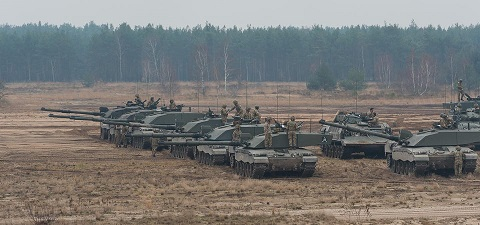

2022-10-18 20:07:45.857440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 20:08:03.320471: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-18 20:08:03.423552: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 20:08:30.019072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

['a number of military vehicles lined up in a field']


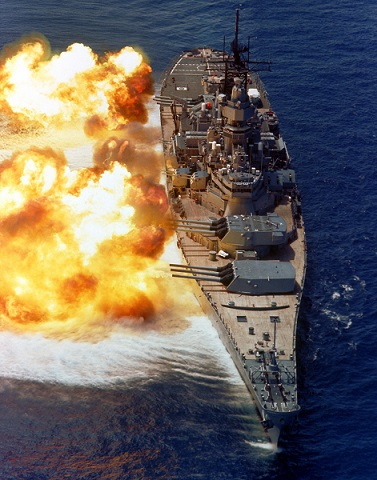

['a navy ship with a bunch of smoke coming out of it']


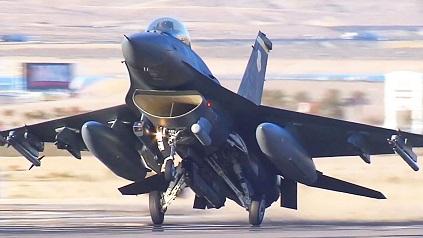

['a fighter jet is flying through the air']


In [5]:
img2txt().predict()

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

{'trained_betas'} was not found in config. Values will be initialized to default values.


  0%|          | 0/51 [00:00<?, ?it/s]

The prompt was "Russian Language"


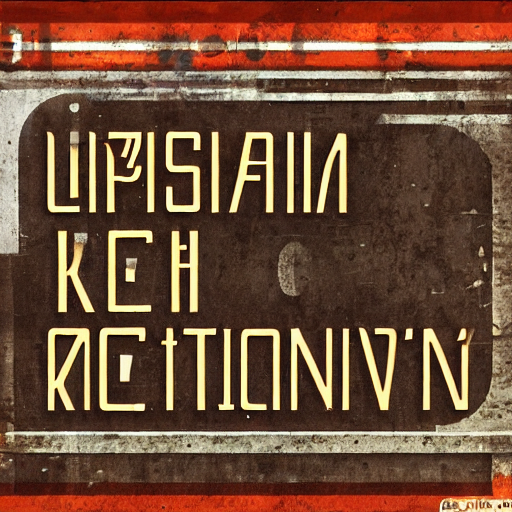

In [6]:
stable_diff().output()